# Spiral Tip detection via the Location-centric method

In [30]:
# (one pot): average potential is the same for all pixels

phase: 
$
\begin{align}
    \theta(t) = \textrm{arctan}\left(V(i,j,t+\tau) - V_{mean}, V(i,j,t) - V_{mean} \right) 
\end{align}
$

In [31]:
from projectlib2 import *

In [32]:
# List of names
# FHN_u
# FHN_wavebreak_u
# FHN_4spirals_u
# barkley_u_1

In [33]:
# Import maps of action potential U[n, i, j]
U = np.load("FHN_wavebreak_u_200.npy") # t_len maps with NxN pixels
V = np.load("FHN_wavebreak_v_200.npy") # t_len maps with NxN pixels

t_len = len(U[:,0,0])     # amount of time steps
N = len(U[0,0,:])         # amount of pixels along one axis
    

### Mean Potential

In [34]:
# average potential over time per pixel
def mean_potential(U):
    ''' for every pixel (i,j) on an NxN map 
        calculate average potential over time '''
    N = len(U[0,0,:])
    
    U_mean = np.zeros((N,N))   
    for i in range(N):                
        for j in range(N):            
            U_mean[i][j] = sum(U[:,i,j])/(N*N)  
    return U_mean

#average potential for all time and pixels
def mean_potential2(U):
    ''' calculate average potential over time & pixels '''
    t_len = len(U[:,0,0])     # amount of time steps
    N = len(U[0,0,:])         # amount of pixels along one axis
    
    summe = 0
    for i in range(N):                
        for j in range(N):    
            for n in range(t_len):
                summe += U[n,i,j] 
    return summe /(t_len*N*N) 

### Method 1: Phase calculations like paper with timeshift

In [35]:
tau = 1
def phase_detection(U, V):
    ''' phase of the potential '''
    U_mean = mean_potential2(U)
    V_mean = mean_potential2(V)
    
    phase = np.zeros(np.shape(U)) 
    for i in range(N):                
        for j in range(N):  
            for n in range(t_len-tau):
                phase[n,i,j] = np.arctan2( (U[n+tau, i, j] - U_mean), (U[n, i, j]   - U_mean))
    return phase 

### Method 2: Torben's analytical phase calculation

In [36]:
def single_phase_timeseries(single_u):     # returns the time series of the phase of the analytic signal for one specific pixel, given the u-timeseries in the pixel
    u_tilde = single_u - np.mean(single_u) # just difference from mean
    z = u_tilde + 1j * hilbert(u_tilde)    # z is the analytic signal, composed using the Hilbert trafo
    phi = np.arctan2(z.imag,z.real)        # phase of the analytic signal
    return phi

def phase_detection2(U, V):
    N = len(U[0,0,:])                      # amount of pixels along one axis
    phases = np.array([[single_phase_timeseries(U[:,j,i]) for i in range(N)] for j in range(N)])
    return phases.transpose(2,0,1)

### Detect Spiral Tips

In [37]:
def tip_detection(U, V, method=1):
    ''' find spiral tips in potential
    for given excited cells U, refractory cells V
    with U & V being n N*N matrixes '''
    if method == 1:
        phases = phase_detection(U, V)
    else:
        phases = phase_detection2(U, V)
        
    tip = np.zeros(np.shape(U)) 
    for i in range(N):                
        for j in range(N):  
             for n in range(t_len-1):
                if (phases[n+1,i,j] - phases[n,i,j] < - np.pi):
                    tip[n,i,j] = 1
                else:
                    tip[n,i,j] = 0
    return tip, phases

#### Calculate Tips

In [38]:
#phase = phase_detection(U, V)
tip, phase = tip_detection(U, V, 1)

#check if anywhere a spiral tip was found:
for i in range(N):                
        for j in range(N):  
             for n in range(t_len-1):
                    if tip[n,i,j] == 1:
                        print(n, i, j)

### Plot just tips


In [28]:
# Plot just tips
def plot_tip(n):
    return plt.imshow(tip[n].reshape(N, N),  cmap="coolwarm")

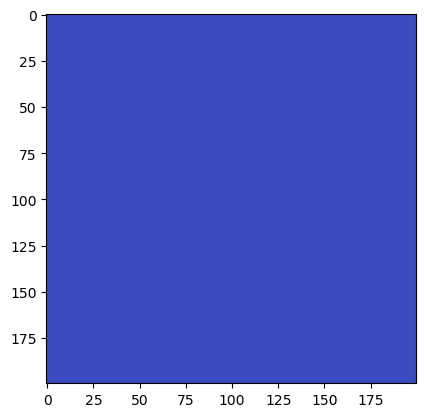

In [29]:
frame_setting = t_len
interval_setting=10000/frame_setting
ani1 = animation.FuncAnimation(plt.gcf(), plot_tip,frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=100)
HTML(ani1.to_html5_video())
#plt.colorbar()


### Plot tips on phase

In [22]:
# Plot Tips on phase
def plot_tip_and_phase(n):
    M = tip[n].reshape(N, N)

    for i in range(N):
        for j in range(N):
            if (M[i][j] == 1):
                plt.scatter(j, i, s=5, facecolors='none', edgecolors='w', alpha=0.20)
    
    plt.imshow(phase[n].reshape(N, N), vmin=-np.pi, vmax=np.pi, cmap="coolwarm")

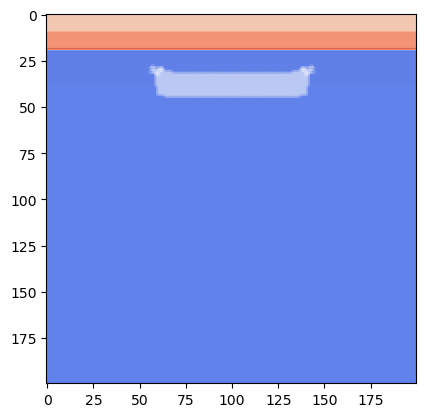

In [23]:
frame_setting = t_len
interval_setting=10000/frame_setting
ani1 = animation.FuncAnimation(plt.gcf(), plot_tip_and_phase, frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=100)
HTML(ani1.to_html5_video())

### Later implement

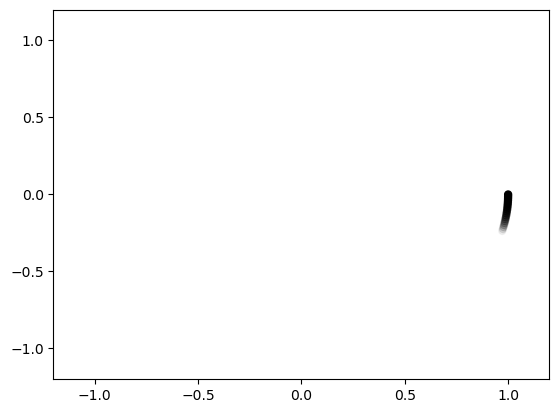

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# PARAMS
trail_length = 20 # data points / frames
trail_alphas = np.linspace(0., 1., trail_length + 1)

animation_fps = 30
n_frames = 500 # also number of data points

# DATA
angles = np.linspace(0., 2. * np.pi, n_frames)
sct_xdata = np.cos(angles)
sct_ydata = np.sin(angles)

#--------
M = tip[n].reshape(N, N)

for i in range(N):
    for j in range(N):
        if (M[i][j] == 1):
            plt.scatter(j, i, s=5, facecolors='none', edgecolors='w', alpha=0.25)
#---------

sct_data = np.stack([sct_xdata, sct_ydata], axis = -1) # shape: (n_frames, 2)

# FIGURE
fig, ax = plt.subplots()
sct = ax.scatter([], [], s = 25., facecolors = 'black')

def init():
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    return sct,

def update(frame_id):
    # For the first few frames, there are not enough past data points for a full trail
    trail_start_id = max(0, frame_id - trail_length) 
    current_trail_length = frame_id - trail_start_id
    
    sct.set_offsets(sct_data[trail_start_id:frame_id+1])
    sct.set_alpha(trail_alphas[-(current_trail_length+1):])

    return sct,

ani = FuncAnimation(fig, update, frames = n_frames, interval = animation_fps,
                    init_func = init, blit = True)
HTML(ani.to_html5_video())

### Just the phase

In [ ]:
def plot_phase(i):
    return plt.imshow(phase[i].reshape(N, N), vmin=0, vmax=1, cmap="coolwarm")

In [ ]:
frame_setting = t_len
interval_setting=10000/frame_setting
ani1 = animation.FuncAnimation(plt.gcf(), plot_phase,frames=frame_setting, interval=interval_setting, blit=False,repeat_delay=100)
HTML(ani1.to_html5_video())

### Rest

In [ ]:
    if (n==0):
        cmap = cm.get_cmap('coolwarm')
        norm = co.Normalize(vmin=-np.pi,vmax=np.pi)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        plt.colorbar(sm, label="time")